# 2D classification tests using simulated data

## General setup

In [1]:
## External modules.
from copy import deepcopy
from matplotlib import cm
from matplotlib.colors import BoundaryNorm
from matplotlib.pyplot import savefig, show, subplots, tight_layout
import matplotlib.pyplot as plt
import numpy as np
from os import path

## Internal modules.
from mml.algos.gd import GD_ERM
from mml.losses.classification import Zero_One
from mml.losses.cvar import CVaR
from mml.losses.dro import DRO_CR
from mml.losses.logistic import Logistic_Binary
from mml.losses.margin import Margin_Binary
from mml.losses.quadratic import Quadratic
from mml.losses.tilted import Tilted
from mml.models.linreg import LinearRegression
from mml.utils import makedir_safe
from mml.utils.linalg import onehot
from setup_algos import GD_ERM_Tilted, GD_ERM_DRO_CR
from setup_dispersions import get_dispersion
from setup_losses import MV_Huber, R_Risk, T_Risk
from setup_results import img_dir, results_dir, my_fontsize, my_ext, export_legend
from setup_train import train_epoch

In [2]:
## Create directory to save figures.
makedir_safe(img_dir)

In [3]:
## Scenario specification.
scenario = "gaussian-spherical"
num_outliers = 1
outlier_factor = -10.0

In [4]:
## Set up random generator.
entropy_common = 58238972897892348023984098239408290222
ss_common = np.random.SeedSequence(entropy_common)
rg_common = np.random.default_rng(seed=ss_common)

In [5]:
## Setup up base losses.
loss_zeroone = Zero_One()
loss_logistic = Logistic_Binary()
loss_hinge = Margin_Binary(hinge=True, threshold=0.0)
loss_unhinged = Margin_Binary(hinge=False, threshold=0.0)
base_loss_dict = {"logistic": loss_logistic, "hinge": loss_hinge, "unhinged": loss_unhinged}

In [6]:
## Scenario details.

label_noise = False #True
fraction_to_flip = 0.05
label_noise_name = "noisy" if label_noise else "noiseless"

if scenario == "uniform-nearby-noisefree":
    
    ## Basic labeller.
    w_star = np.array([-1.0, 1.0])
    w_0_star = 0.0
    
    ## Feature distribution.
    feature_type = "uniform-square"
    
    ## Label assignment.
    label_type = "hplane"
    
    ## Shifting of the features (positive pushes apart, negative merges).
    shift_horiz = 0.0
    shift_vert = 0.0
    
    ## Sample size.
    n_tr = 100
    
    ## Algorithm parameters.
    step_size = 0.01
    num_steps = 20000
    
    ## Initial value.
    paras_init = {"w": np.array([1.0, 1.0, 0.0]).reshape(3,1)}
    
    ## Manually set limits.
    set_limits = True
    y_top = 1.5 + shift_vert
    y_bottom = -0.5 - shift_vert
    x_right = 1.5 + shift_horiz
    x_left = -0.5 - shift_horiz
    
elif scenario == "gaussian-spherical":

    ## Basic labeller.
    w_star = np.array([-1.0, 1.0])
    w_0_star = 0.0
    
    ## Feature distribution.
    feature_type = "gaussian-spherical"
    
    ## Label assignment.
    label_type = "hplane"
    
    ## Shifting of the features (positive pushes apart, negative merges).
    shift_horiz = 0.0
    shift_vert = 0.0
    
    ## Sample size.
    n_tr = 100
    
    ## Algorithm parameters.
    step_size = 0.01
    num_steps = 20000
    
    ## Initial value.
    paras_init = {"w": np.array([1.0, 1.0, 0.0]).reshape(3,1)}
    
    ## Manually set limits.
    set_limits = False
    y_top = 1.0 + shift_vert
    y_bottom = -1.0 - shift_vert
    x_right = 1.0 + shift_horiz
    x_left = -1.0 - shift_horiz

elif scenario == "gaussian-spherical-unbalanced":

    ## Basic labeller.
    w_star = np.array([-1.0, 1.0])
    w_0_star = 0.0
    
    ## Feature distribution.
    feature_type = "gaussian-spherical-unbalanced"
    
    ## Label assignment.
    label_type = "hplane"
    
    ## Shifting of the features (positive pushes apart, negative merges).
    shift_horiz = 0.0
    shift_vert = 0.0
    
    ## Sample size.
    n_tr = 500
    frac_pos = 0.95
    frac_neg = 1.0-frac_pos
    
    ## Algorithm parameters.
    step_size = 0.2
    num_steps = 10000
    
    ## Initial value.
    paras_init = {"w": np.array([1.0, 1.0, 0.0]).reshape(3,1)} # perpendicular to true line.
    
    ## Manually set limits.
    set_limits = True
    y_top = 1.25 + shift_vert
    y_bottom = -1.25 - shift_vert
    x_right = 1.25 + shift_horiz
    x_left = -1.25 - shift_horiz

elif scenario == "gaussian-asymmetric":

    ## Basic labeller.
    w_star = np.array([-1.0, 1.0])
    w_0_star = 0.0
    
    ## Feature distribution.
    feature_type = "gaussian-asymmetric"
    
    ## Label assignment.
    label_type = "hplane"
    
    ## Shifting of the features (positive pushes apart, negative merges).
    shift_horiz = 0.0
    shift_vert = 0.0
    
    ## Sample size.
    n_tr = 100
    
    ## Algorithm parameters.
    step_size = 0.01
    num_steps = 20000
    
    ## Initial value.
    paras_init = {"w": np.array([1.0, 1.0, 0.0]).reshape(3,1)}
    
    ## Manually set limits.
    set_limits = False
    y_top = 1.0 + shift_vert
    y_bottom = -1.0 - shift_vert
    x_right = 1.0 + shift_horiz
    x_left = -1.0 - shift_horiz
    
else:
    raise ValueError("Provide a proper scenario name.")


In [7]:
## Helper functions and clerical variables.

def uniform_square(n, rg):
    '''
    Generate inputs in a uniform fashion on the unit square.
    '''
    return rg.uniform(size=(n,2))


def gaussian_spherical(n, rg):
    mean_positive = np.array([-0.25, 0.25])
    mean_negative = np.array([0.25, -0.25])
    cov = np.vstack([[0.01,0.0], [0.0,0.01]])
    return np.vstack([rg.multivariate_normal(mean=mean_positive, cov=cov, size=n//2),
                      rg.multivariate_normal(mean=mean_negative, cov=cov, size=n//2)])


def gaussian_spherical_unbalanced(npos, nneg, rg):
    mean_positive = np.array([-0.25, 0.25])
    mean_negative = np.array([0.25, -0.25])
    cov = np.vstack([[0.01,0.0], [0.0,0.01]])
    return np.vstack([rg.multivariate_normal(mean=mean_positive, cov=cov, size=npos),
                      rg.multivariate_normal(mean=mean_negative, cov=cov, size=nneg)])


def gaussian_asymmetric(n, rg):
    mean_positive = np.array([-0.25, 0.25]).reshape(1,2)
    mean_negative = np.array([0.25, -0.25]).reshape(1,2)
    rad_positive = -np.pi/4.0
    rad_negative = np.pi/4.0
    cov = np.vstack([[0.001, 0.0], [0.0, 0.05]])
    rotate_positive = np.vstack([[np.cos(rad_positive), -np.sin(rad_positive)],
                                 [np.sin(rad_positive), np.cos(rad_positive)]])
    rotate_negative = np.vstack([[np.cos(rad_negative), -np.sin(rad_negative)],
                                 [np.sin(rad_negative), np.cos(rad_negative)]])
    out_positive = np.matmul(rotate_positive,
                             rg.multivariate_normal(mean=mean_positive.reshape(-1),
                                                    cov=cov, size=n//2).T).T
    out_positive += mean_positive
    out_negative = np.matmul(rotate_negative,
                             rg.multivariate_normal(mean=mean_negative.reshape(-1),
                                                    cov=cov, size=n//2).T).T
    out_negative += mean_negative
    
    return np.vstack([out_positive, out_negative])


def linear_separator(X):
    '''
    Assign labels based on a pre-specified hyperplane.
    '''
    return np.where(np.dot(X, w_star) >= w_0_star, 1, 0).reshape(len(X),1)

In [8]:
## Function for generating inputs and labels.

def get_generate_features(feature_type, rg):
    if feature_type == "uniform-square":
        return lambda n: uniform_square(n=n, rg=rg)
    elif feature_type == "gaussian-spherical":
        return lambda n: gaussian_spherical(n=n, rg=rg)
    elif feature_type == "gaussian-spherical-unbalanced":
        return lambda n: gaussian_spherical_unbalanced(npos=int(n*frac_pos), nneg=int(n*frac_neg), rg=rg)
    elif feature_type == "gaussian-asymmetric":
        return lambda n: gaussian_asymmetric(n=n, rg=rg)
    else:
        raise ValueError("Did not recognize feature_type given.")

def get_assign_labels(label_type, rg):
    if label_type == "hplane":
        return lambda X: linear_separator(X=X)
    else:
        raise ValueError("Did not recognize label_type given.")

In [9]:
## Generate some training data.
generate_features = get_generate_features(feature_type=feature_type, rg=rg_common)
assign_labels = get_assign_labels(label_type=label_type, rg=rg_common)
X_tr = generate_features(n=n_tr)
y_tr = assign_labels(X=X_tr)
y_tr_onehot = onehot(y=y_tr, num_classes=2)

## If desired, randomly flip some labels.
if label_noise:
    num_to_flip = int(np.ceil(fraction_to_flip*len(X_tr)))
    idx_to_flip = rg_common.choice(a=len(X_tr), size=num_to_flip)
    y_tr[idx_to_flip,:] = np.where(y_tr[idx_to_flip,:] == 1, 0, 1)

## If desired, randomly perturb some feature vectors.
if num_outliers > 0:
    idx_outliers = rg_common.choice(a=len(X_tr), size=num_outliers)
    X_tr[idx_outliers] = outlier_factor*X_tr[idx_outliers]

## Organize the positive and negative classes.
idx_positive = y_tr.reshape(-1) == 1
idx_negative = y_tr.reshape(-1) == 0
y_tr_pmone = np.where(y_tr == 1, y_tr, -1) # set to plus/minus 1.

## Shifting (note the signs).
X_tr[idx_positive,0] -= shift_horiz
X_tr[idx_positive,1] += shift_vert
X_tr[idx_negative,0] += shift_horiz
X_tr[idx_negative,1] -= shift_vert

## Pad the training features with -1.
X_tr_padded = np.hstack([X_tr, -np.ones((len(X_tr),1), dtype=X_tr.dtype)]) # pad with -1.

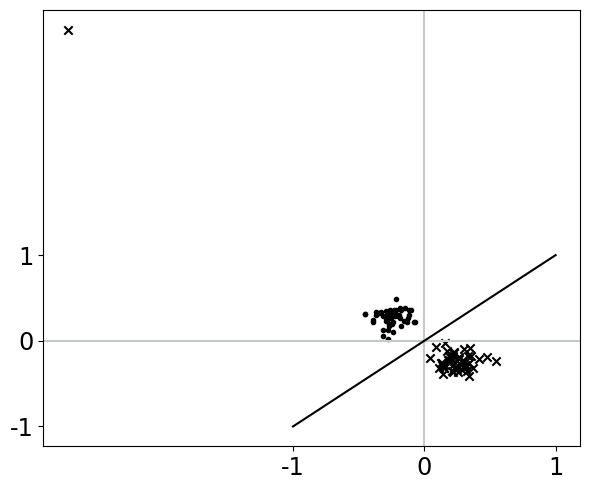

In [10]:
## Visualize the labelled training data.
fig, ax = plt.subplots(1, 1, figsize=(6,5))
ax.axvline(x=0.0, color="xkcd:silver")
ax.axhline(y=0.0, color="xkcd:silver")
x_values = np.linspace(x_left, x_right, 100)
y_values = (w_0_star/w_star[1]) - (w_star[0]/w_star[1])*x_values
ax.plot(x_values, y_values, color="xkcd:black")
ax.scatter(X_tr[idx_positive,0], X_tr[idx_positive,1], marker=".", color="xkcd:black")
ax.scatter(X_tr[idx_negative,0], X_tr[idx_negative,1], marker="x", color="xkcd:black")
if label_noise:
    ax.scatter(X_tr[idx_to_flip,0], X_tr[idx_to_flip,1], marker="D", facecolors="none", edgecolors="xkcd:red")
ax.tick_params(labelsize=my_fontsize)
#if set_limits:
#    ax.set_ylim(bottom=y_bottom, top=y_top)
#    ax.set_xlim(left=x_left, right=x_right)
ticks = [-1.0, 0.0, 1.0]
tick_labels = ["-1", "0", "1"]
ax.set_xticks(ticks)
ax.set_xticklabels(tick_labels)
ax.set_yticks(ticks)
ax.set_yticklabels(tick_labels)
fname = path.join(img_dir, "class2d_{}_{}.{}".format(scenario, label_noise_name, my_ext))
plt.tight_layout()
plt.savefig(fname=fname)
plt.show()

## Loss distributions under different initial values

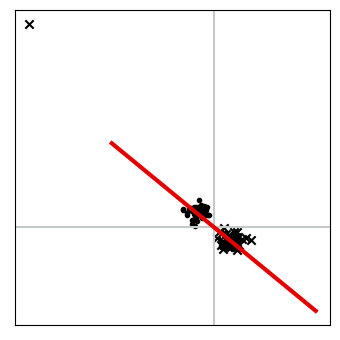

--Logistic--
Mean + StdDev (1): 1.1904155603556372
Mean + StdDev (2): 1.3234376486912742
--Hinge--
Mean + StdDev (1): 0.8203408799036918
Mean + StdDev (2): 0.9844304302367972
--Unhinged--
Mean + StdDev (1): 0.8054112085963827
Mean + StdDev (2): 0.9022603547476624


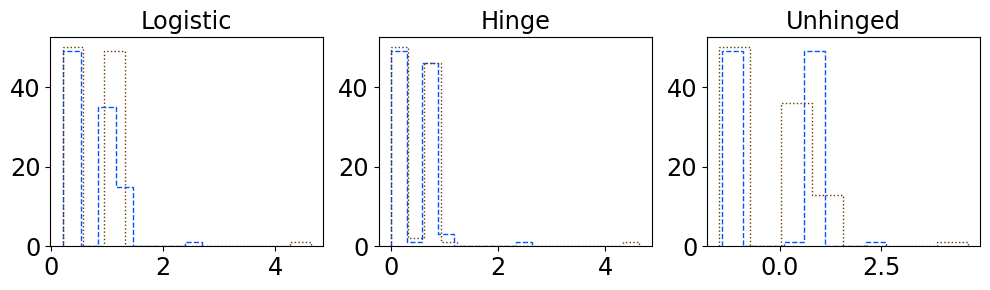

In [11]:
## Visualize some alternative candidates and their loss distributions.

w_init_bad_1 = np.array([0.0, 1.0, 1.0]).reshape(3,1)
w_init_bad_2 = np.array([0.0, 1.0, -1.0]).reshape(3,1)
w_init_nearzero = np.array([1.0, 1.0, 0.0]).reshape(3,1)
w_init_dict = {"mostwrong": w_init_bad_1,
               "mostright": w_init_bad_2,
               "nearzero": w_init_nearzero}
paras_init_bad_1 = {"w": w_init_bad_1}
paras_init_bad_2 = {"w": w_init_bad_2}
paras_init_nearzero = {"w": w_init_nearzero}

model_1 = LinearRegression(num_features=X_tr_padded.shape[1],
                           paras_init=deepcopy(paras_init_bad_1),
                           rg=rg_common)
model_2 = LinearRegression(num_features=X_tr_padded.shape[1],
                           paras_init=deepcopy(paras_init_bad_2),
                           rg=rg_common)
model_nearzero = LinearRegression(num_features=X_tr_padded.shape[1],
                           paras_init=deepcopy(paras_init_nearzero),
                           rg=rg_common)

fig, ax = plt.subplots(1, 1, figsize=(3.5,3.5))
ax.axvline(x=0.0, color="xkcd:silver")
ax.axhline(y=0.0, color="xkcd:silver")
x_values = np.linspace(x_left-0.5, x_right+0.5, 100)
y_values_1 = (w_init_bad_1[2]/w_init_bad_1[1]) - (w_init_bad_1[0]/w_init_bad_1[1])*x_values
y_values_2 = (w_init_bad_2[2]/w_init_bad_2[1]) - (w_init_bad_2[0]/w_init_bad_2[1])*x_values
y_values_nearzero = (w_init_nearzero[2]/w_init_nearzero[1]) - (w_init_nearzero[0]/w_init_nearzero[1])*x_values
#ax.plot(x_values, y_values_1, linewidth=3.0, color="xkcd:electric blue", ls="dashed")
#ax.plot(x_values, y_values_2, linewidth=3.0, color="xkcd:brown", ls="dotted")
ax.plot(x_values, y_values_nearzero, linewidth=3.0, color="xkcd:red", ls="solid")
ax.scatter(X_tr[idx_positive,0], X_tr[idx_positive,1], marker=".", color="xkcd:black")
ax.scatter(X_tr[idx_negative,0], X_tr[idx_negative,1], marker="x", color="xkcd:black")
if label_noise:
    ax.scatter(X_tr[idx_to_flip,0], X_tr[idx_to_flip,1], marker="D", facecolors="none", edgecolors="xkcd:red")
ax.tick_params(labelsize=my_fontsize)
if set_limits:
    ax.set_ylim(bottom=y_bottom, top=y_top)
    ax.set_xlim(left=x_left, right=x_right)
ticks = [] #[-1.0, 0.0, 1.0]
tick_labels = [] #["-1", "0", "1"]
ax.set_xticks(ticks)
ax.set_xticklabels(tick_labels)
ax.set_yticks(ticks)
ax.set_yticklabels(tick_labels)
fname = path.join(img_dir, "class2d_{}_{}_badinits.{}".format(scenario, label_noise_name, my_ext))
plt.tight_layout()
plt.savefig(fname=fname)
plt.show()

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10,3), sharey=False)

tmp_losses_1 = loss_logistic(model=model_1, X=X_tr_padded, y=y_tr_pmone)
tmp_losses_2 = loss_logistic(model=model_2, X=X_tr_padded, y=y_tr_pmone)
ax1.hist(tmp_losses_1,
         bins="auto", color="xkcd:electric blue", ls="dashed", histtype="step",
         fill=False, hatch=None, orientation="vertical", density=False)
ax1.hist(tmp_losses_2,
         bins="auto", color="xkcd:brown", ls="dotted", histtype="step",
         fill=False, hatch=None, orientation="vertical", density=False)
ax1.set_title("Logistic", size=my_fontsize)
ax1.tick_params(labelsize=my_fontsize)
print("--Logistic--")
print("Mean + StdDev (1):", np.mean(tmp_losses_1)+np.std(tmp_losses_1))
print("Mean + StdDev (2):", np.mean(tmp_losses_2)+np.std(tmp_losses_2))

tmp_losses_1 = loss_hinge(model=model_1, X=X_tr_padded, y=y_tr_pmone)
tmp_losses_2 = loss_hinge(model=model_2, X=X_tr_padded, y=y_tr_pmone)
ax2.hist(tmp_losses_1,
         bins="auto", color="xkcd:electric blue", ls="dashed", histtype="step",
         fill=False, hatch=None, orientation="vertical", density=False)
ax2.hist(tmp_losses_2,
         bins="auto", color="xkcd:brown", ls="dotted", histtype="step",
         fill=False, hatch=None, orientation="vertical", density=False)
ax2.set_title("Hinge", size=my_fontsize)
ax2.tick_params(labelsize=my_fontsize)
print("--Hinge--")
print("Mean + StdDev (1):", np.mean(tmp_losses_1)+np.std(tmp_losses_1))
print("Mean + StdDev (2):", np.mean(tmp_losses_2)+np.std(tmp_losses_2))

tmp_losses_1 = loss_unhinged(model=model_1, X=X_tr_padded, y=y_tr_pmone)
tmp_losses_2 = loss_unhinged(model=model_2, X=X_tr_padded, y=y_tr_pmone)
ax3.hist(tmp_losses_1,
         bins="auto", color="xkcd:electric blue", ls="dashed", histtype="step",
         fill=False, hatch=None, orientation="vertical", density=False)
ax3.hist(tmp_losses_2,
         bins="auto", color="xkcd:brown", ls="dotted", histtype="step",
         fill=False, hatch=None, orientation="vertical", density=False)
ax3.set_title("Unhinged", size=my_fontsize)
ax3.tick_params(labelsize=my_fontsize)
print("--Unhinged--")
print("Mean + StdDev (1):", np.mean(tmp_losses_1)+np.std(tmp_losses_1))
print("Mean + StdDev (2):", np.mean(tmp_losses_2)+np.std(tmp_losses_2))

fname = path.join(img_dir, "class2d_{}_{}_lossdists.{}".format(scenario, label_noise_name, my_ext))
plt.tight_layout()
plt.savefig(fname=fname)
plt.show()

In [12]:
## A few handy wrappers that grab model/loss/algo objects as desired.

def get_model(risk_name, rg, **kwargs):
    model = LinearRegression(num_features=kwargs["num_features"], rg=rg)
    model.paras["w"] = deepcopy(kwargs["w_init"]).reshape(model.paras["w"].shape)
    if risk_name == "mvHuber":
        model.paras["location"] = rg.uniform(low=0.0, high=0.05, size=(1,1))
        model.paras["scale"] = rg.uniform(low=0.975, high=1.025, size=(1,1))
    elif risk_name == "cvar":
        model.paras["v"] = rg.uniform(low=0.0, high=0.05, size=(1,1))
    elif risk_name == "dro":
        model.paras["theta"] = rg.uniform(low=0.0, high=0.05, size=(1,1))
    elif risk_name == "erm":
        pass # Nothing special to do in this case.
    else:
        raise ValueError("Please pass a proper risk class name.")
    return model


def get_loss(risk_name, loss_base, **kwargs):
    if risk_name == "mvHuber":
        return MV_Huber(loss_base=loss_base,
                        alpha=kwargs["alpha"],
                        beta=kwargs["beta"],
                        lam=kwargs["lam"])
    elif risk_name == "cvar":
        return CVaR(loss_base=loss_base, alpha=1.0-kwargs["prob"])
    elif risk_name == "dro":
        c = 2.0
        cstar = c / (c-1.0)
        a = ((1.0/(1.0-kwargs["atilde"]))-1.0)**2.0 / 2.0
        return DRO_CR(loss_base=loss_base, bound=a, shape=c)
    elif risk_name == "erm":
        return loss_base
    else:
        raise ValueError("Please pass a proper risk class name.")


def get_algo(risk_name, model, loss, **kwargs):
    if risk_name == "mvHuber":
        return GD_ERM(step_coef=kwargs["step_size"], model=model, loss=loss)
    elif risk_name == "cvar":
        return GD_ERM(step_coef=kwargs["step_size"], model=model, loss=loss)
    elif risk_name == "dro":
        c = 2.0
        cstar = c / (c-1.0)
        a = ((1.0/(1.0-kwargs["atilde"]))-1.0)**2.0 / 2.0
        return GD_ERM_DRO_CR(bound=a, shape=c, step_coef=kwargs["step_size"],
                             model=model, loss=loss)
    elif risk_name == "erm":
        return GD_ERM(step_coef=kwargs["step_size"], model=model, loss=loss)
    else:
        raise ValueError("Please pass a proper risk class name.")

### Initial comparison of all risk classes (with M-risk and T-risk over $\alpha$)

In [13]:
## Setup of risk hyperparameters.
todo_risks = ["erm", "mvHuber", "cvar", "dro"]
todo_riskparas = {
    "erm": ("dummy", [1.0]),
    "mvHuber": ("beta", np.linspace(0.1, 0.9, 5)),
    "cvar": ("prob", np.linspace(0.025, 0.75, 5)),
    "dro": ("atilde", np.linspace(0.025, 0.35, 5))
}
aux_riskparas = {
    "erm": {},
    "mvHuber": {},
    "cvar": {},
    "dro": {}
}
risk_names = {"erm": "Vanilla ERM",
              "mvHuber": "Modified Sun-Huber",
              "cvar": "CVaR",
              "dro": r"$\chi^{2}$-DRO risk"}
para_names = {"alpha": r"$\alpha$",
              "beta": r"$\beta$",
              "prob": r"$\beta$",
              "gamma": r"$\gamma$",
              "atilde": r"$\widetilde{a}$"}

In [14]:
## Experimental settings.
base_name = "logistic"
loss_base = base_loss_dict[base_name]
step_size = 0.01
num_steps = 15000
w_init_name = "nearzero"
model_kwargs = {"num_features": X_tr_padded.shape[1],
                "w_init": w_init_dict[w_init_name]}
algo_kwargs = {"step_size": step_size}

In [15]:
## Storage preparation.
storage_base = {risk: {} for risk in todo_risks}
storage_obj = {risk: {} for risk in todo_risks}
storage_norm = {risk: {} for risk in todo_risks}
storage_zeroone = {risk: {} for risk in todo_risks}
storage_mstd = {risk: {} for risk in todo_risks}

In [16]:
## Loop over the risk class.
for risk in todo_risks:
    
    print("Working on '{}' class...".format(risk))
    
    pname, riskparas = todo_riskparas[risk]
    aux_paras = aux_riskparas[risk]
    
    ## Loop over the individual risks.
    for riskpara in riskparas:
        
        ## Get the relevant model.
        model = get_model(risk_name=risk, rg=rg_common, **model_kwargs)
        
        ## Set any remaining parameters to be passed.
        if risk == "mvHuber":
            aux_paras[pname] = riskpara / np.sqrt(len(X_tr_padded))
            aux_paras["alpha"] = aux_paras[pname] # just set alpha=beta.
            aux_paras["lam"] = np.log(len(X_tr_padded)) / np.sqrt(len(X_tr_padded))
        else:
            aux_paras[pname] = riskpara
        
        ## Get the relevant loss and algo we need.
        loss = get_loss(risk_name=risk, loss_base=loss_base, **aux_paras)
        algo = get_algo(risk_name=risk, model=model, loss=loss, **aux_paras, **algo_kwargs)
        
        ## Get to work on learning.
        losses_base = []
        losses_obj = []
        losses_zeroone = []
        losses_mstd = []
        norms = []
        for step in range(num_steps):
            algo.update(X=X_tr_padded, y=y_tr_pmone)
            losses_base += [np.mean(loss_base(model=model, X=X_tr_padded, y=y_tr_pmone))]
            losses_obj += [np.mean(loss(model=model, X=X_tr_padded, y=y_tr_pmone))]
            losses_zeroone += [np.mean(model(X=X_tr_padded)*y_tr_pmone <= 0.0)]
            losses_mstd += [np.mean(loss_base(model=model, X=X_tr_padded, y=y_tr_pmone))+np.std(loss_base(model=model, X=X_tr_padded, y=y_tr_pmone))]
            norms += [np.linalg.norm(model.paras["w"])]
        
        ## Having finished the learning loop, store information of interest.
        storage_zeroone[risk][riskpara] = np.array(losses_zeroone)
        storage_norm[risk][riskpara] = np.array(norms)
        storage_base[risk][riskpara] = np.array(losses_base)
        storage_obj[risk][riskpara] = np.array(losses_obj)
        storage_mstd[risk][riskpara] = np.array(losses_mstd)

Working on 'erm' class...
Working on 'mvHuber' class...
Working on 'cvar' class...
Working on 'dro' class...


erm ...
0: Final error rate 0.01


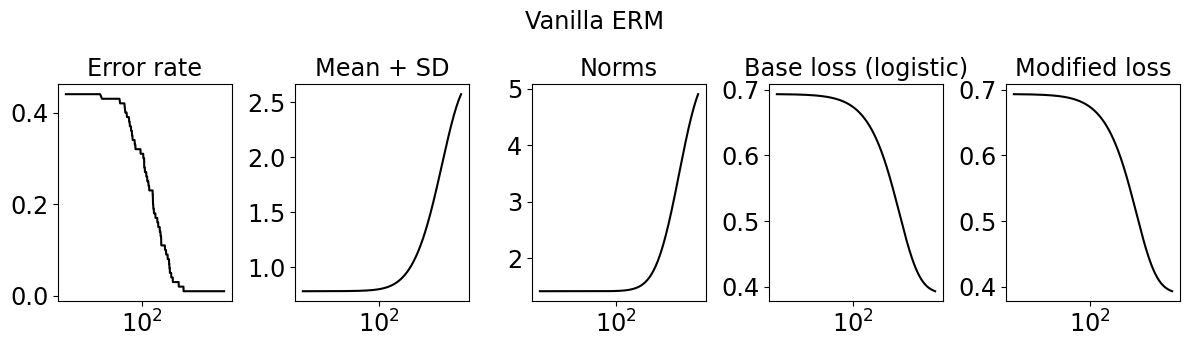

mvHuber ...
0: Final error rate 0.62
1: Final error rate 0.6
2: Final error rate 0.55
3: Final error rate 0.01
4: Final error rate 0.01


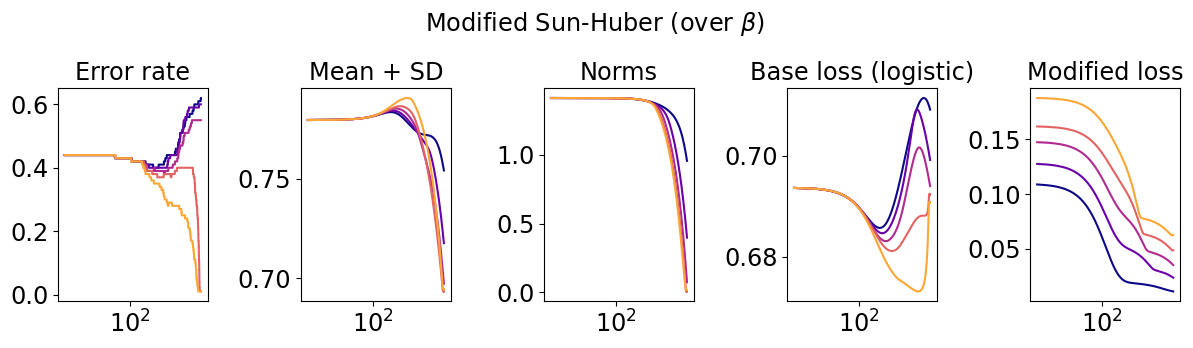

cvar ...
0: Final error rate 0.01
1: Final error rate 0.01
2: Final error rate 0.01
3: Final error rate 0.01
4: Final error rate 0.01


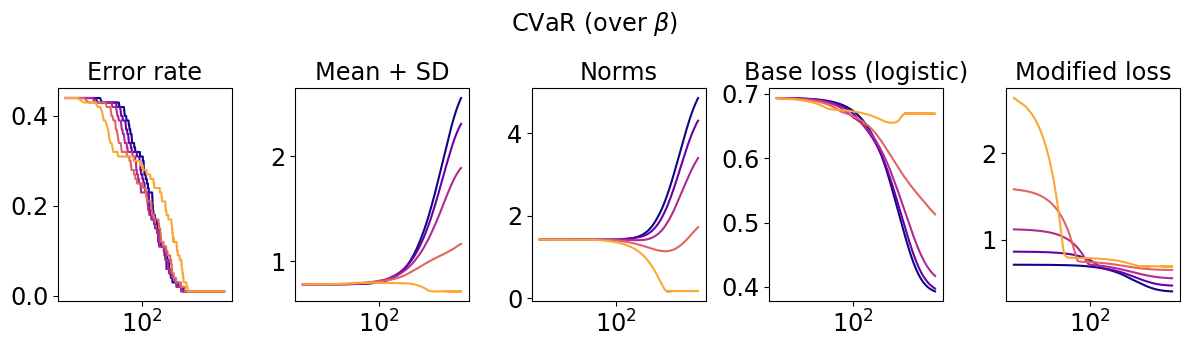

dro ...
0: Final error rate 0.01
1: Final error rate 0.01
2: Final error rate 0.02
3: Final error rate 0.09
4: Final error rate 0.13


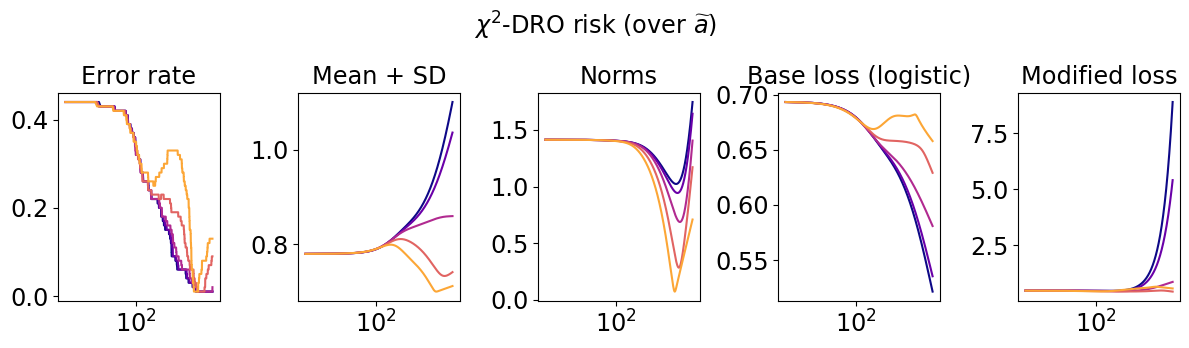

In [17]:
## Similar double loop, this time for visualizing the results.
for risk in todo_risks:
    
    print(risk, "...")
    
    pname, riskparas = todo_riskparas[risk]
    aux_paras = aux_riskparas[risk]
    
    ## Initial figure work.
    fig, (ax_zeroone, ax_mstd, ax_norms, ax_base, ax_obj) = subplots(1, 5, figsize=(12,3.5))
    
    ## Colour setup.
    if risk == "erm":
        colours = ["xkcd:black"]
    else:
        cmap = cm.get_cmap("plasma")
        colours = []
        for i in range(len(riskparas)):
            colours += [cmap(i/len(riskparas))]
    
    ## Loop over the individual risks.
    for i, riskpara in enumerate(riskparas):
        
        ## Get relevant values from storage.
        losses_zeroone = storage_zeroone[risk][riskpara]
        losses_base = storage_base[risk][riskpara]
        losses_obj = storage_obj[risk][riskpara]
        losses_mstd = storage_mstd[risk][riskpara]
        norms = storage_norm[risk][riskpara]
        
        ## Get plotting.
        ax_zeroone.semilogx(np.arange(1, num_steps+1, 1), losses_zeroone, color=colours[i])
        ax_mstd.semilogx(np.arange(1, num_steps+1, 1), losses_mstd, color=colours[i])
        ax_norms.semilogx(np.arange(1, num_steps+1, 1), norms, color=colours[i])
        ax_base.semilogx(np.arange(1, num_steps+1, 1), losses_base, color=colours[i])
        ax_obj.semilogx(np.arange(1, num_steps+1, 1), losses_obj, color=colours[i])
        
        ## For reference, print the final error rate.
        print(str(i)+":", "Final error rate", losses_zeroone[-1])
    
    ## Colorbar.
    #bounds = riskparas
    #cmap = cm.get_cmap("plasma")
    #norm = BoundaryNorm(bounds, cmap.N, extend="both")
    #cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cm.get_cmap("plasma")),
    #                    ax=ax_obj, label='digit value')
    #cbar.set_ticks([bounds.min(), bounds.max()])
    #cbar.set_ticklabels([str(bounds.min()), str(bounds.max())])
    
    ## Labels and such.
    ax_zeroone.set_title("Error rate", size=my_fontsize)
    ax_mstd.set_title("Mean + SD", size=my_fontsize)
    ax_norms.set_title("Norms", size=my_fontsize)
    ax_base.set_title("Base loss ({})".format(base_name), size=my_fontsize)
    ax_obj.set_title("Modified loss", size=my_fontsize)
    ax_zeroone.tick_params(labelsize=my_fontsize)
    ax_mstd.tick_params(labelsize=my_fontsize)
    ax_norms.tick_params(labelsize=my_fontsize)
    ax_base.tick_params(labelsize=my_fontsize)
    ax_obj.tick_params(labelsize=my_fontsize)
    if risk == "erm":
        fig.suptitle("{}".format(risk_names[risk]), size=my_fontsize)
    else:
        fig.suptitle("{} (over {})".format(risk_names[risk], para_names[pname]), size=my_fontsize)
    fname = path.join(img_dir, "class2d_{}_{}_separable_{}_{}.{}".format(scenario, label_noise_name, risk, w_init_name, my_ext))
    tight_layout()
    savefig(fname=fname)
    show()

erm ...
mvHuber ...
cvar ...
dro ...


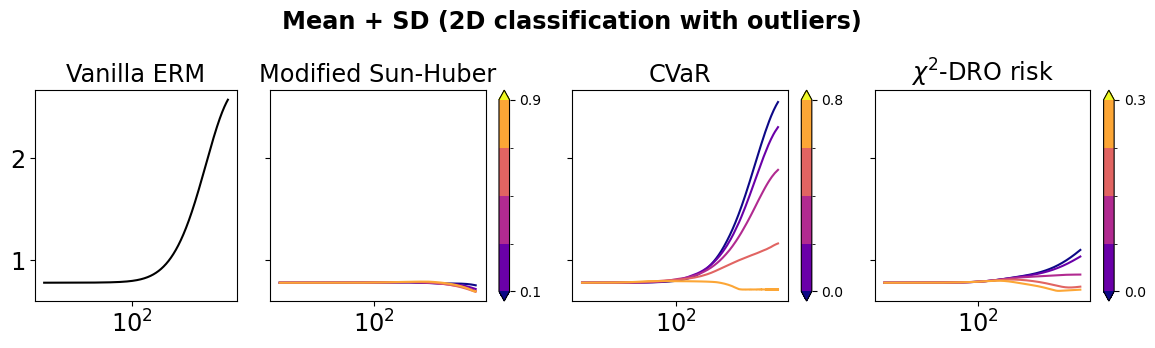

In [18]:
## Plot just mean+std(base) side by side.

fig, axes = subplots(1, len(todo_risks), figsize=(12,3.5), sharey=True,
                     gridspec_kw={"width_ratios": [1.5]+(len(todo_risks)-1)*[2.0]})

for j, risk in enumerate(todo_risks):
    
    print(risk, "...")
    
    pname, riskparas = todo_riskparas[risk]
    aux_paras = aux_riskparas[risk]
    
    ax = axes[j]

    ## Colour setup.
    if risk == "erm":
        colours = ["xkcd:black"]
    else:
        cmap = cm.get_cmap("plasma")
        colours = []
        for i in range(len(riskparas)):
            colours += [cmap(i/len(riskparas))]
    
    ## Loop over the individual risks.
    for i, riskpara in enumerate(riskparas):
        
        ## Get relevant values from storage.
        losses_mstd = storage_mstd[risk][riskpara]
        
        ## Get plotting.
        ax.semilogx(np.arange(1, num_steps+1, 1), losses_mstd, color=colours[i])
    
    ## Colorbar.
    if risk != "erm":
        bounds = riskparas
        cmap = cm.get_cmap("plasma")
        norm = BoundaryNorm(bounds, cmap.N, extend="both")
        cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cm.get_cmap("plasma")),
                            ax=ax)
        cbar.set_ticks([bounds.min(), bounds.max()])
        # Rounding to keep visuals clean.
        cbar.set_ticklabels(["{:.1f}".format(bounds.min()), "{:.1f}".format(bounds.max())])
    
    ## Labels and such.
    ax.set_title(risk_names[risk], size=my_fontsize)
    ax.tick_params(labelsize=my_fontsize)
    
if w_init_name == "mostwrong":
    fig.suptitle("Mean + SD (initial point: mostly incorrect)", size=my_fontsize, fontweight="bold")
elif w_init_name == "mostright":
    fig.suptitle("Mean + SD (initial point: mostly correct)", size=my_fontsize, fontweight="bold")
elif w_init_name == "nearzero":
    fig.suptitle("Mean + SD (2D classification with outliers)", size=my_fontsize, fontweight="bold")
    
fname = path.join(img_dir, "class2d_{}_{}_mstdcomp_{}.{}".format(scenario, label_noise_name, w_init_name, my_ext))
tight_layout()
savefig(fname=fname)
show()


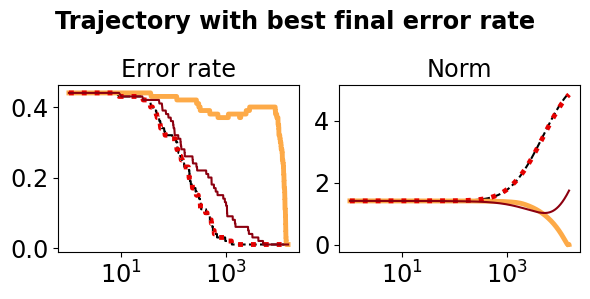

In [19]:
## Just plot the misclassification rate and norms.

## Colour setup.
colours_dict = {"trisk": "xkcd:blue",
                "mvHuber": "xkcd:light orange",
                "cvar": "xkcd:red",
                "entropic": "xkcd:jade",
                "dro": "xkcd:crimson",
                "erm": "xkcd:black"}
linestyles_dict = {"trisk": "solid",
                   "mvHuber": "solid",
                   "cvar": "dotted",
                   "entropic": "solid",
                   "dro": "solid",
                   "erm": "dashed"}
linewidths_dict = {"trisk": 3.5,
                   "mvHuber": 3.5,
                   "cvar": 3.5,
                   "entropic": 3.5,
                   "dro": 1.5,
                   "erm": 1.5}
                   
colours = [colours_dict[risk] for risk in todo_risks]
linestyles = [linestyles_dict[risk] for risk in todo_risks]
linewidths = [linewidths_dict[risk] for risk in todo_risks]

## Initial figure work.
fig, (ax_zeroone, ax_norms) = subplots(1, 2, figsize=(6,3), sharex=True, sharey=False)

## Loop over risk classes.
for i, risk in enumerate(todo_risks):
    
    pname, riskparas = todo_riskparas[risk]
    aux_paras = aux_riskparas[risk]
    
    ## Choose the particular risk setting that led to the best final 0-1 error.
    final_values = np.array([storage_zeroone[risk][riskpara][-1] for riskpara in riskparas])
    best_idx = np.argmin(final_values)
    
    ## Specify the risk function to evaluate.
    riskpara = riskparas[best_idx] #riskparas[len(riskparas)-1]
    
    ## Get relevant values from storage.
    losses_zeroone = storage_zeroone[risk][riskpara]
    losses_base = storage_base[risk][riskpara]
    losses_obj = storage_obj[risk][riskpara]
    norms = storage_norm[risk][riskpara]
        
    ## Get plotting.
    ax_zeroone.semilogx(np.arange(1, num_steps+1, 1), losses_zeroone,
                        color=colours[i],
                        linestyle=linestyles[i],
                        linewidth=linewidths[i])
    ax_norms.semilogx(np.arange(1, num_steps+1, 1), norms,
                      color=colours[i],
                      linestyle=linestyles[i],
                      linewidth=linewidths[i])
    
## Labels and such.
ax_zeroone.set_title("Error rate", size=my_fontsize)
ax_norms.set_title("Norm", size=my_fontsize)
ax_zeroone.tick_params(labelsize=my_fontsize)
ax_norms.tick_params(labelsize=my_fontsize)
if w_init_name == "mostwrong":
    fig.suptitle("Initial point: mostly incorrect", size=my_fontsize, fontweight="bold")
elif w_init_name == "mostright":
    fig.suptitle("Initial point: mostly correct", size=my_fontsize, fontweight="bold")
elif w_init_name == "nearzero":
    fig.suptitle("Trajectory with best final error rate", size=my_fontsize, fontweight="bold")
fname = path.join(img_dir, "class2d_{}_{}_separable_compact_{}.{}".format(scenario, label_noise_name, w_init_name, my_ext))
tight_layout()
savefig(fname=fname)
show()

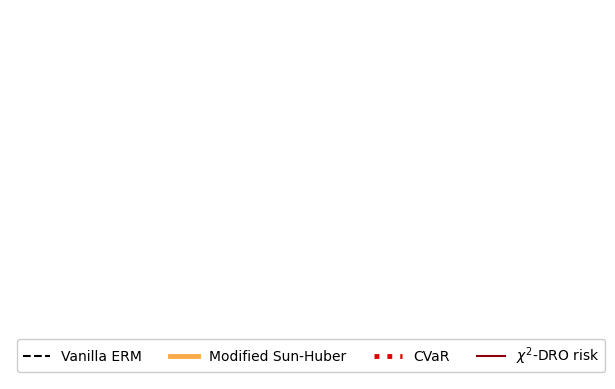

In [20]:
## Legends.

labels = [risk_names[risk] for risk in todo_risks]
f = lambda m,c,l,lw: plt.plot([],[],marker=m, color=c, ls=l, linewidth=lw)[0]
handles = [f(None, colours[i], linestyles[i], linewidths[i]) for i in range(len(labels))]
our_legend = plt.legend(handles, labels, loc=3, ncol=5, framealpha=1, frameon=True)
fname = path.join(img_dir, "class2d_{}_{}_separable_{}_legend.{}".format(scenario, label_noise_name, w_init_name, my_ext))
export_legend(legend=our_legend, filename=fname)
show()


___